In [1]:
import json
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [2]:
device = torch.device('cpu')
dtype = torch.float32

In [3]:
# Importing the dataset.
# The LIDAR server produces samples at 30Hz with object positions normalized in their
# space, i.e. x and y values are in the 0-1 range.
datadir = Path("../testdata")
names = [
    "dump-1731964073793.jsonl",
    "dump-1731965089198.jsonl",
    "dump-1731966752296.jsonl"
]

data = []
for name in names:
    path = datadir.joinpath(datadir, name)
    f = open(path, 'r')
    last_is_zero = False
    for line in f.readlines():
        d = json.loads(line)
        if d['type'] != 'object':
            continue
        payload = d['payload']
        # At the beginning and end of the session there is nobody on stage and
        # there are many 0,0 points.
        is_zero = payload['x'] == 0 and payload['y'] == 0
        if is_zero:
            continue
            
        data.append({
            'x': payload['x'],
            'y': payload['y'],
        })

In [6]:
class SequenceToSequenceDataset(Dataset):
    # Instead of predicting the next point, we make the network predict
    # the next trajectory. This way, it will be forced to imitate the
    # behaviour of the training setup.
    def __init__(self, data, sequence_length=10):
        self.sequence_length = sequence_length
        
        # Convert data to numpy array
        xy_points = np.array([[d['x'], d['y']] for d in data])
        
        # Create sequences
        self.sequences = []
        self.targets = []
        
        for i in range(len(xy_points) - (sequence_length * 2)):
            start = i
            mid = i + sequence_length
            end = mid + sequence_length
            
            self.sequences.append(xy_points[start:mid])
            self.targets.append(xy_points[mid:end])
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.as_tensor([self.sequences[idx], self.targets[idx]])

In [27]:
# Checking that the dataset works.
dataset = SequenceToSequenceDataset(data)
next(iter(dataset)).shape

torch.Size([2, 10, 2])

In [12]:
class TrajectoryPredictor(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, lstm_layers=2, dense_layers=[64, 32, 16], output_dim=2):
        super(TrajectoryPredictor, self).__init__()
        
        # LSTM layers for temporal processing
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True
        )
        
        # Fully connected layers for further feature processing
        dense_layers_list = []
        input_size = hidden_dim
        for layer_size in dense_layers:
            dense_layers_list.append(nn.Linear(input_size, layer_size))
            dense_layers_list.append(nn.ReLU())
            input_size = layer_size
        self.fc = nn.Sequential(*dense_layers_list)
        
        # Output layer with Sigmoid activation
        self.output_layer = nn.Linear(input_size, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x: (batch_size, input_sequence_length, input_dim)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, input_sequence_length, hidden_dim)
        dense_out = self.fc(lstm_out)  # Pass each timestep's hidden state through dense layers
        output = self.sigmoid(self.output_layer(dense_out))  # Output: (batch_size, input_sequence_length, output_dim)
        return output

In [18]:
# Checking that the model works
model = TrajectoryPredictor()
with torch.no_grad():
    dummy_input = torch.rand(1, 5, 2)
    # Forward pass
    output = model(dummy_input)
    print(output) 

tensor([[[0.4477, 0.5259],
         [0.4476, 0.5258],
         [0.4476, 0.5257],
         [0.4475, 0.5257],
         [0.4475, 0.5257]]])


In [30]:
from torch.utils.data import DataLoader, random_split

# Initialize the dataset
dataset = SequenceToSequenceDataset(data, sequence_length=10)

# Define split ratios
train_ratio = 0.8
val_ratio = 0.2

# Compute split sizes
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32  # Adjust batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [29]:
i = next(iter(train_loader))
i.shape

torch.Size([32, 2, 10, 2])

In [32]:
# Training
from accelerate import Accelerator
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Initialize Accelerator
accelerator = Accelerator()

# Define model, optimizer, and loss function
model = TrajectoryPredictor()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()  # Mean Squared Error for position regression

# Prepare everything with Accelerate
model, optimizer, train_loader, val_loader = accelerator.prepare(
    model, optimizer, train_loader, val_loader
)

# Training loop
num_epochs = 100
patience = 10  # Early stopping patience
best_val_loss = float("inf")
epochs_without_improvement = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        inputs, targets = batch[:, 0], batch[:, 1]

        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs, targets)  # Compute loss
        accelerator.backward(loss)  # Backpropagation using Accelerate
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            inputs, targets = batch[:, 0], batch[:, 1]
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # Log results
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save the best model
        accelerator.save_state(f"best_model_epoch_{epoch + 1}")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered!")
            break

# Final cleanup
print("Training complete. Best Validation Loss:", best_val_loss)

Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 421.58it/s]


Epoch 1/100 - Train Loss: 0.0116, Val Loss: 0.0014


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 558.04it/s]


Epoch 2/100 - Train Loss: 0.0013, Val Loss: 0.0013


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 556.75it/s]


Epoch 3/100 - Train Loss: 0.0011, Val Loss: 0.0010


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 548.13it/s]


Epoch 4/100 - Train Loss: 0.0008, Val Loss: 0.0008


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 580.99it/s]


Epoch 5/100 - Train Loss: 0.0007, Val Loss: 0.0005


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 560.58it/s]


Epoch 6/100 - Train Loss: 0.0006, Val Loss: 0.0005


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 574.21it/s]


Epoch 7/100 - Train Loss: 0.0005, Val Loss: 0.0004


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 519.58it/s]


Epoch 8/100 - Train Loss: 0.0005, Val Loss: 0.0005


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 531.47it/s]


Epoch 9/100 - Train Loss: 0.0004, Val Loss: 0.0004


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 548.06it/s]


Epoch 10/100 - Train Loss: 0.0004, Val Loss: 0.0004


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 489.96it/s]


Epoch 11/100 - Train Loss: 0.0004, Val Loss: 0.0004


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 486.52it/s]


Epoch 12/100 - Train Loss: 0.0004, Val Loss: 0.0004


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 483.21it/s]


Epoch 13/100 - Train Loss: 0.0004, Val Loss: 0.0004


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 532.49it/s]


Epoch 14/100 - Train Loss: 0.0004, Val Loss: 0.0004


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 514.96it/s]


Epoch 15/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 506.29it/s]


Epoch 16/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 530.19it/s]


Epoch 17/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 519.33it/s]


Epoch 18/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 530.83it/s]


Epoch 19/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 525.33it/s]


Epoch 20/100 - Train Loss: 0.0003, Val Loss: 0.0004


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 540.46it/s]


Epoch 21/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 580.09it/s]


Epoch 22/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 559.62it/s]


Epoch 23/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 563.83it/s]


Epoch 24/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 555.98it/s]


Epoch 25/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 533.58it/s]


Epoch 26/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 545.47it/s]


Epoch 27/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 515.87it/s]


Epoch 28/100 - Train Loss: 0.0003, Val Loss: 0.0004


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 536.96it/s]


Epoch 29/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 564.90it/s]


Epoch 30/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 539.99it/s]


Epoch 31/100 - Train Loss: 0.0003, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 557.37it/s]


Epoch 32/100 - Train Loss: 0.0003, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 552.99it/s]


Epoch 33/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 554.88it/s]


Epoch 34/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 558.92it/s]


Epoch 35/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 560.84it/s]


Epoch 36/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 559.87it/s]


Epoch 37/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 560.77it/s]


Epoch 38/100 - Train Loss: 0.0003, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 546.09it/s]


Epoch 39/100 - Train Loss: 0.0003, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 560.07it/s]


Epoch 40/100 - Train Loss: 0.0003, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 541.95it/s]


Epoch 41/100 - Train Loss: 0.0003, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 545.58it/s]


Epoch 42/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 541.93it/s]


Epoch 43/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 574.22it/s]


Epoch 44/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 555.90it/s]


Epoch 45/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 549.71it/s]


Epoch 46/100 - Train Loss: 0.0002, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 545.86it/s]


Epoch 47/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 559.90it/s]


Epoch 48/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 552.60it/s]


Epoch 49/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 545.22it/s]


Epoch 50/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 555.43it/s]


Epoch 51/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 557.06it/s]


Epoch 52/100 - Train Loss: 0.0002, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 551.03it/s]


Epoch 53/100 - Train Loss: 0.0002, Val Loss: 0.0004


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 587.68it/s]


Epoch 54/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 597.66it/s]


Epoch 55/100 - Train Loss: 0.0002, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 581.12it/s]


Epoch 56/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 576.92it/s]


Epoch 57/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 589.82it/s]


Epoch 58/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 582.95it/s]


Epoch 59/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 577.28it/s]


Epoch 60/100 - Train Loss: 0.0002, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 597.63it/s]


Epoch 61/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 576.85it/s]


Epoch 62/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 596.31it/s]


Epoch 63/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 590.50it/s]


Epoch 64/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 586.99it/s]


Epoch 65/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 580.86it/s]


Epoch 66/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 591.01it/s]


Epoch 67/100 - Train Loss: 0.0002, Val Loss: 0.0003


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 604.81it/s]


Epoch 68/100 - Train Loss: 0.0002, Val Loss: 0.0002


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 542.34it/s]

Epoch 69/100 - Train Loss: 0.0002, Val Loss: 0.0002
Early stopping triggered!
Training complete. Best Validation Loss: 0.00020900721866597016


In [37]:
import torch
from safetensors.torch import load_file

trained_model = TrajectoryPredictor()

safetensors_file = "../model/model.safetensors"

# Load the parameters from the safetensors file
state_dict = load_file(safetensors_file)

# Load the state_dict into your model
trained_model.load_state_dict(state_dict)

# Move model to the appropriate device (e.g., CPU or GPU)
device = torch.device("mps")
trained_model.to(device)

TrajectoryPredictor(
  (lstm): LSTM(2, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=16, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [189]:
eval_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
item = next(iter(eval_loader))
item

tensor([[[[0.4752, 0.6233],
          [0.4746, 0.6257],
          [0.4740, 0.6279],
          [0.4734, 0.6297],
          [0.4727, 0.6311],
          [0.4719, 0.6319],
          [0.4710, 0.6323],
          [0.4701, 0.6321],
          [0.4692, 0.6314],
          [0.4683, 0.6302]],

         [[0.4659, 0.6256],
          [0.4641, 0.6219],
          [0.4627, 0.6190],
          [0.4604, 0.6132],
          [0.4586, 0.6086],
          [0.4571, 0.6047],
          [0.4559, 0.6012],
          [0.4548, 0.5978],
          [0.4538, 0.5946],
          [0.4513, 0.5868]]]], device='mps:0')

In [190]:
have = item.reshape(20, 2)[:10].detach().cpu()

with torch.no_grad():
    predicted = trained_model(have.unsqueeze(0).to(device))

predicted = predicted.squeeze(0).detach().cpu()
print(predicted)
plot_data = torch.cat((have, predicted), dim=0)

tensor([[0.4782, 0.6170],
        [0.4745, 0.6401],
        [0.4779, 0.6371],
        [0.4730, 0.6364],
        [0.4699, 0.6350],
        [0.4670, 0.6320],
        [0.4655, 0.6285],
        [0.4640, 0.6245],
        [0.4624, 0.6200],
        [0.4608, 0.6154]])


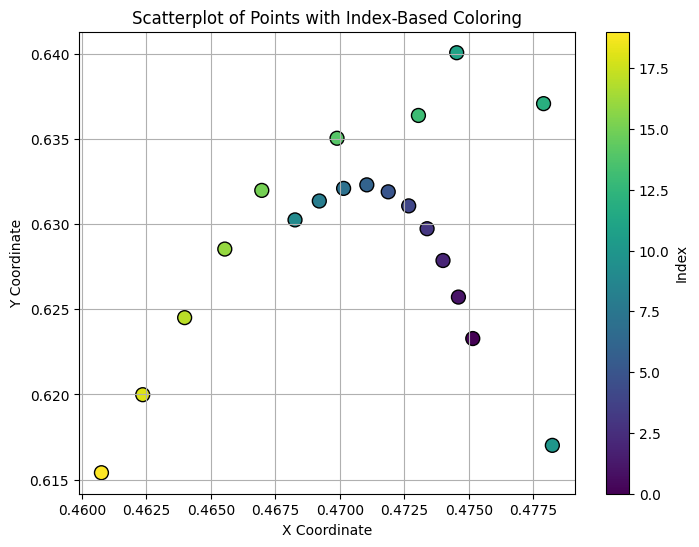

In [191]:
import matplotlib.pyplot as plt
import numpy as np

# Extract x, y coordinates
x, y = plot_data[:, 0], plot_data[:, 1]

# Generate colors based on indices
colors = np.arange(len(plot_data))

# Create scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=colors, cmap='viridis', s=100, edgecolor='k')

# Add colorbar
plt.colorbar(scatter, label="Index")

# Add labels and grid
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Scatterplot of Points with Index-Based Coloring")
plt.grid(True)
plt.show()